In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from joblib import Parallel, delayed
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_random_state  
import matplotlib.pyplot as plt

## scenario reduction



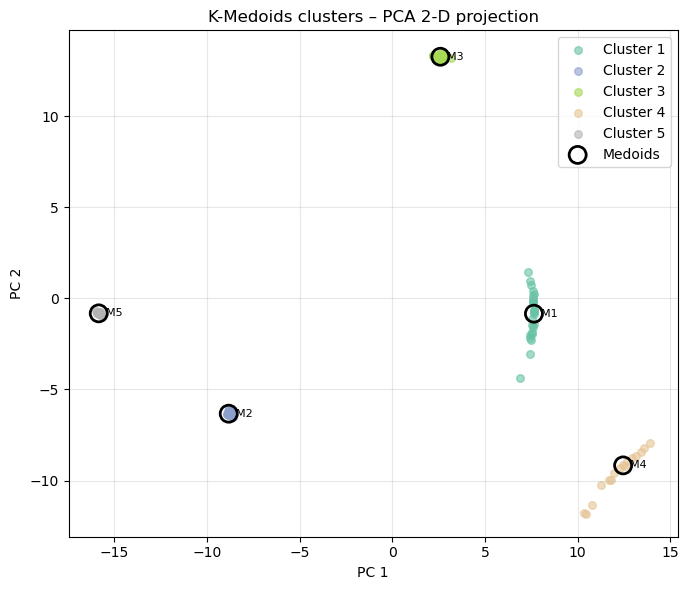

In [2]:

# ---------- Load scenarios ----------
synthetic = np.load("model weights/residual_sims.npy")    # (N, 517, 3)
N = synthetic.shape[0]
k = 5            # number of medoids selected earlier

# ----------  Flatten each scenario to a 1‑D vector  ----------
flat_sequence = synthetic.reshape(N, -1)   # shape (N, 517*3 = 1551)

# ----------  Run PCA to 2 components  ----------
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(flat_sequence)

# Re-run K‑Medoids to obtain labels and medoids
def l2_multichannel(seq1, seq2):
    return np.linalg.norm(seq1.ravel() - seq2.ravel())

# Distance matrix (small N so OK)
def _pair(i, j):
    return i, j, l2_multichannel(synthetic[i], synthetic[j])

pairs = [(i, j) for i in range(N) for j in range(i+1, N)]
results = Parallel(n_jobs=-1)(delayed(_pair)(i, j) for i, j in pairs)
D = np.zeros((N, N))
for i, j, d in results:
    D[i, j] = D[j, i] = d

class KMedoids:
    def __init__(self, n_clusters=5, max_iter=100, random_state=42):
        self.k = n_clusters
        self.max_iter = max_iter
        self.rs = check_random_state(random_state)
    def _init_pp(self, D):
        n = D.shape[0]
        medoids = [self.rs.randint(n)]
        dist_near = D[:, medoids[0]].copy()
        for _ in range(1, self.k):
            probs = dist_near**2 
            probs /= probs.sum()
            new = self.rs.choice(n, p=probs)
            medoids.append(new)
            dist_near = np.minimum(dist_near, D[:, new])
        return np.array(medoids)
    def fit(self, D):
        N = D.shape[0]
        medoids = self._init_pp(D)
        labels  = np.argmin(D[:, medoids], axis=1)
        for _ in range(self.max_iter):
            changed = False
            for pos in range(self.k):
                for h in range(N):
                    if h in medoids: continue
                    trial = medoids.copy()
                    trial[pos] = h
                    new_labels = np.argmin(D[:, trial], axis=1)
                    old_cost = D[np.arange(N), medoids[labels]].sum()
                    new_cost = D[np.arange(N), trial[new_labels]].sum()
                    if new_cost < old_cost:
                        medoids, labels = trial, new_labels
                        changed = True
            if not changed: break
        self.medoid_indices_ = medoids
        self.labels_ = labels
        return self

kmed = KMedoids(n_clusters=k).fit(D)
labels = kmed.labels_
medoid_idx = kmed.medoid_indices_

# Plot PCA scatter with medoids  
plt.figure(figsize=(7,6))
colors = plt.cm.Set2(np.linspace(0,1,k))
for c in range(k):
    mask = labels == c
    plt.scatter(coords[mask,0], coords[mask,1], color=colors[c], alpha=0.6, s=30, label=f"Cluster {c+1}")
plt.scatter(coords[medoid_idx,0], coords[medoid_idx,1], facecolors='none', edgecolors='k', s=150,
            linewidths=2, label="Medoids")
for i, idx in enumerate(medoid_idx):
    plt.text(coords[idx,0], coords[idx,1], f"  M{i+1}", va='center', fontsize=8)
plt.title("K-Medoids clusters – PCA 2‑D projection")
plt.xlabel("PC 1"); plt.ylabel("PC 2")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


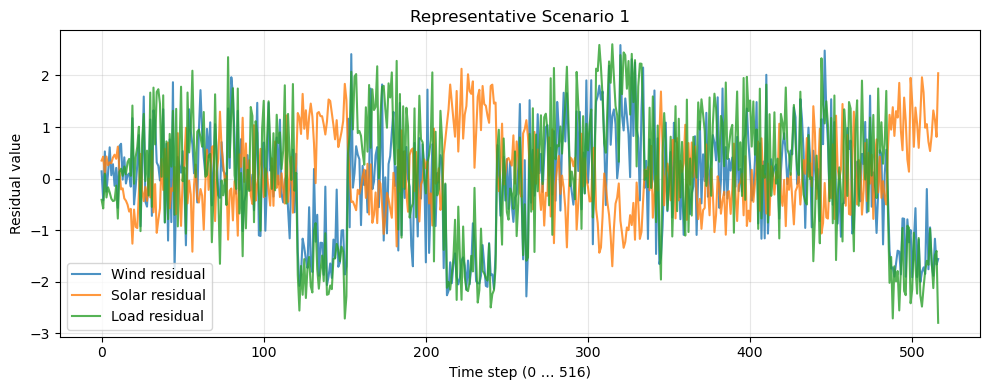

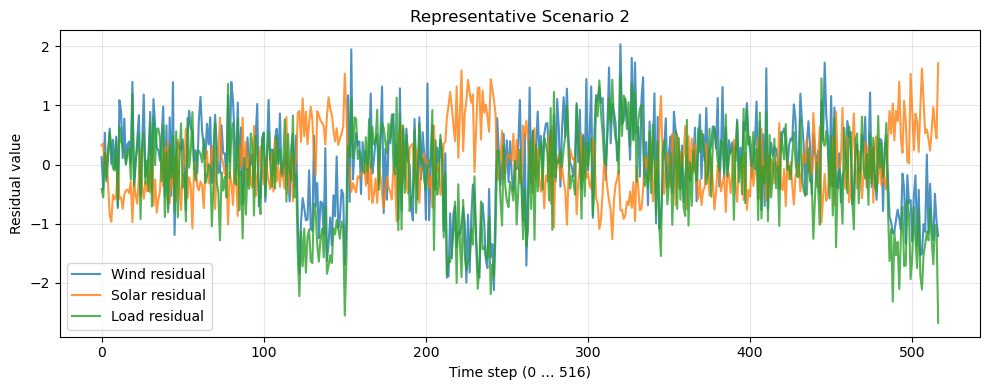

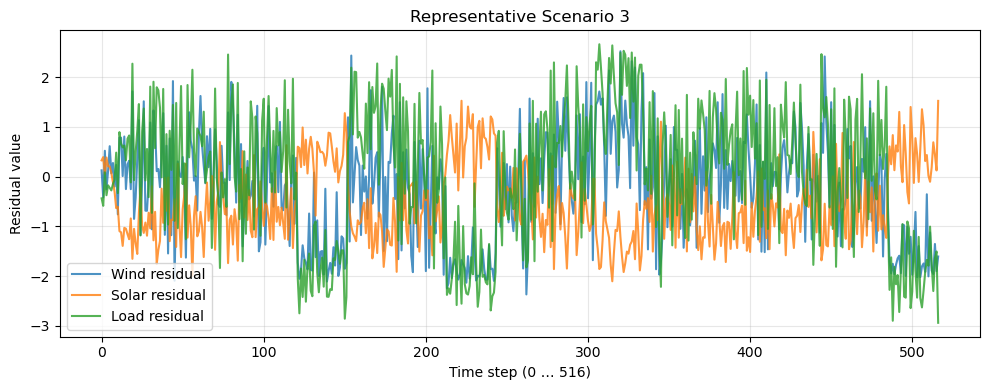

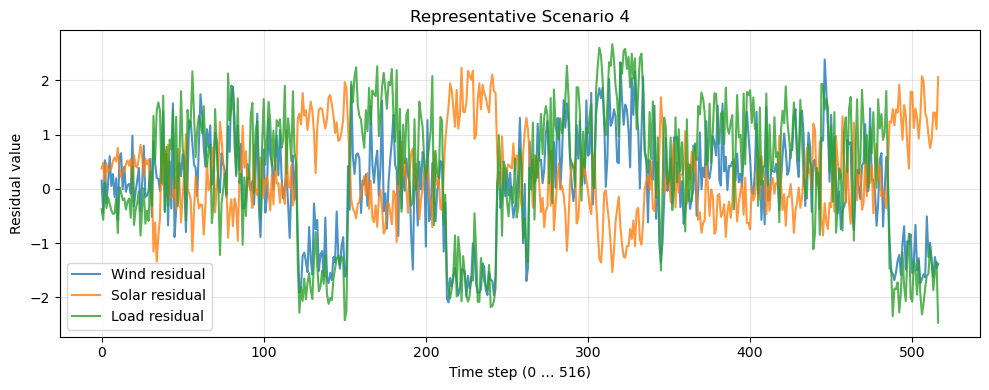

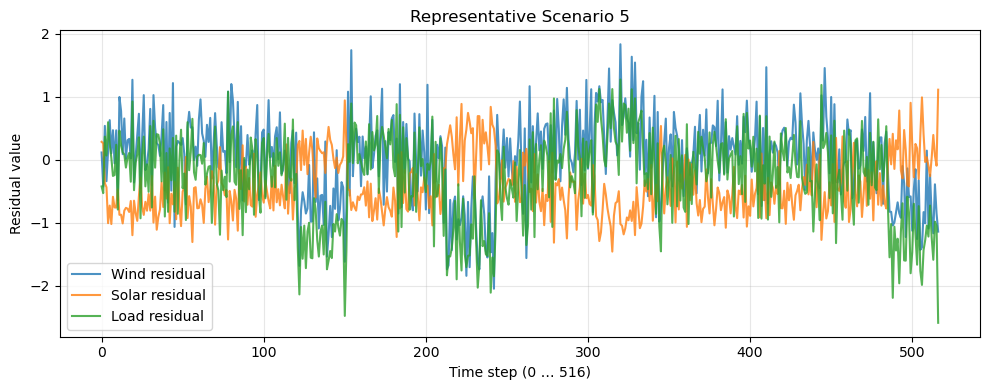

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os

selected= synthetic[medoid_idx]
scenarios, steps, _ = selected.shape
channels = ["Wind residual", "Solar residual", "Load residual"]

# One figure per scenario, with all three channels overlaid
for i in range(scenarios):
    plt.figure(figsize=(10, 4))
    for ch in range(3):
        plt.plot(selected[i, :, ch], label=channels[ch], alpha=0.8)
    plt.title(f"Representative Scenario {i + 1}")
    plt.xlabel("Time step (0 … 516)")
    plt.ylabel("Residual value")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


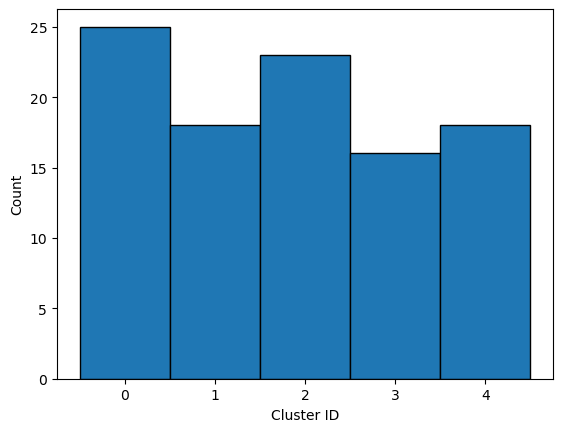

In [8]:
## the cluster representation
plt.hist(labels, bins=np.arange(6) - 0.5, edgecolor='black')

# Correct xticks call: a 1-D sequence of positions
plt.xticks(np.arange(0, 5))

plt.xlabel("Cluster ID")
plt.ylabel("Count")
plt.show()

## Adding back the trend 

In [9]:
forecasted_trend= pd.read_csv("2024-2025.csv")
trend=forecasted_trend[["Wind_Trend","Solar_Trend","Load_Trend"]]

In [46]:
## inverse transforming the scaled residuals
from joblib import load
scaler=load("scaler_model.joblib")
scenarios=scaler.inverse_transform(selected.reshape(-1,3)).reshape(selected.shape)

In [47]:
actual_scenario=pd.DataFrame()
for i, rep_scenario in enumerate(scenarios):
    col=[f"{pow}_{i+1}"for pow in ["Wind","Solar","Load"]]
    actual_scenario[col]=trend+ rep_scenario
    
    
    

In [48]:
actual_scenario

,Wind_1,Solar_1,Load_1,Wind_2,Solar_2,Load_2,Wind_3,Solar_3,Load_3,Wind_4,Solar_4,Load_4,Wind_5,Solar_5,Load_5
0,1187.024125,253.392997,6736.935454,1179.880437,251.214993,6735.394896,1181.169198,251.718066,6726.622847,1193.236367,255.744206,6753.416823,1176.805970,248.180457,6732.946074
1,926.936986,259.929166,6663.615485,926.870641,254.054234,6674.187842,930.155446,257.264783,6660.875235,918.269749,264.521096,6667.194632,926.658910,246.394444,6686.383459
2,1366.585984,232.411795,6959.664243,1371.829636,218.624115,7002.939100,1364.368058,229.189381,6956.088598,1367.615876,236.454173,6967.459490,1373.243745,193.403392,7080.037565
3,1005.975148,260.370931,6756.717077,993.093244,239.680547,6813.508260,1006.455747,256.861776,6754.108938,1001.974652,264.598669,6762.573461,966.787915,188.018487,6948.373100
4,1176.109296,246.242803,6843.112691,1189.286508,194.665697,7024.978734,1178.240758,242.133152,6841.505269,1171.639245,250.157572,6849.580746,1188.100205,140.243973,7180.428021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,536.729444,363.479423,6174.584446,841.000226,341.487182,6309.648838,434.259229,308.490969,6097.035557,668.244336,369.116561,6298.485203,890.141401,295.620576,6333.020420
513,436.602456,403.688314,5942.523632,716.121988,374.425932,6134.900585,403.944253,350.772260,5866.224010,558.151346,410.922132,6055.862987,769.825235,325.942564,6179.394847
514,769.227239,388.700581,6223.037890,1080.757925,347.683926,6427.652331,683.340703,329.950264,6156.427722,727.869695,410.939655,6200.864856,1130.382726,298.500987,6444.624194
515,537.166841,360.871264,6258.701380,863.991151,330.056715,6393.823542,430.671602,303.507421,6215.063746,633.201387,385.472292,6284.469569,917.072145,285.216798,6415.441920


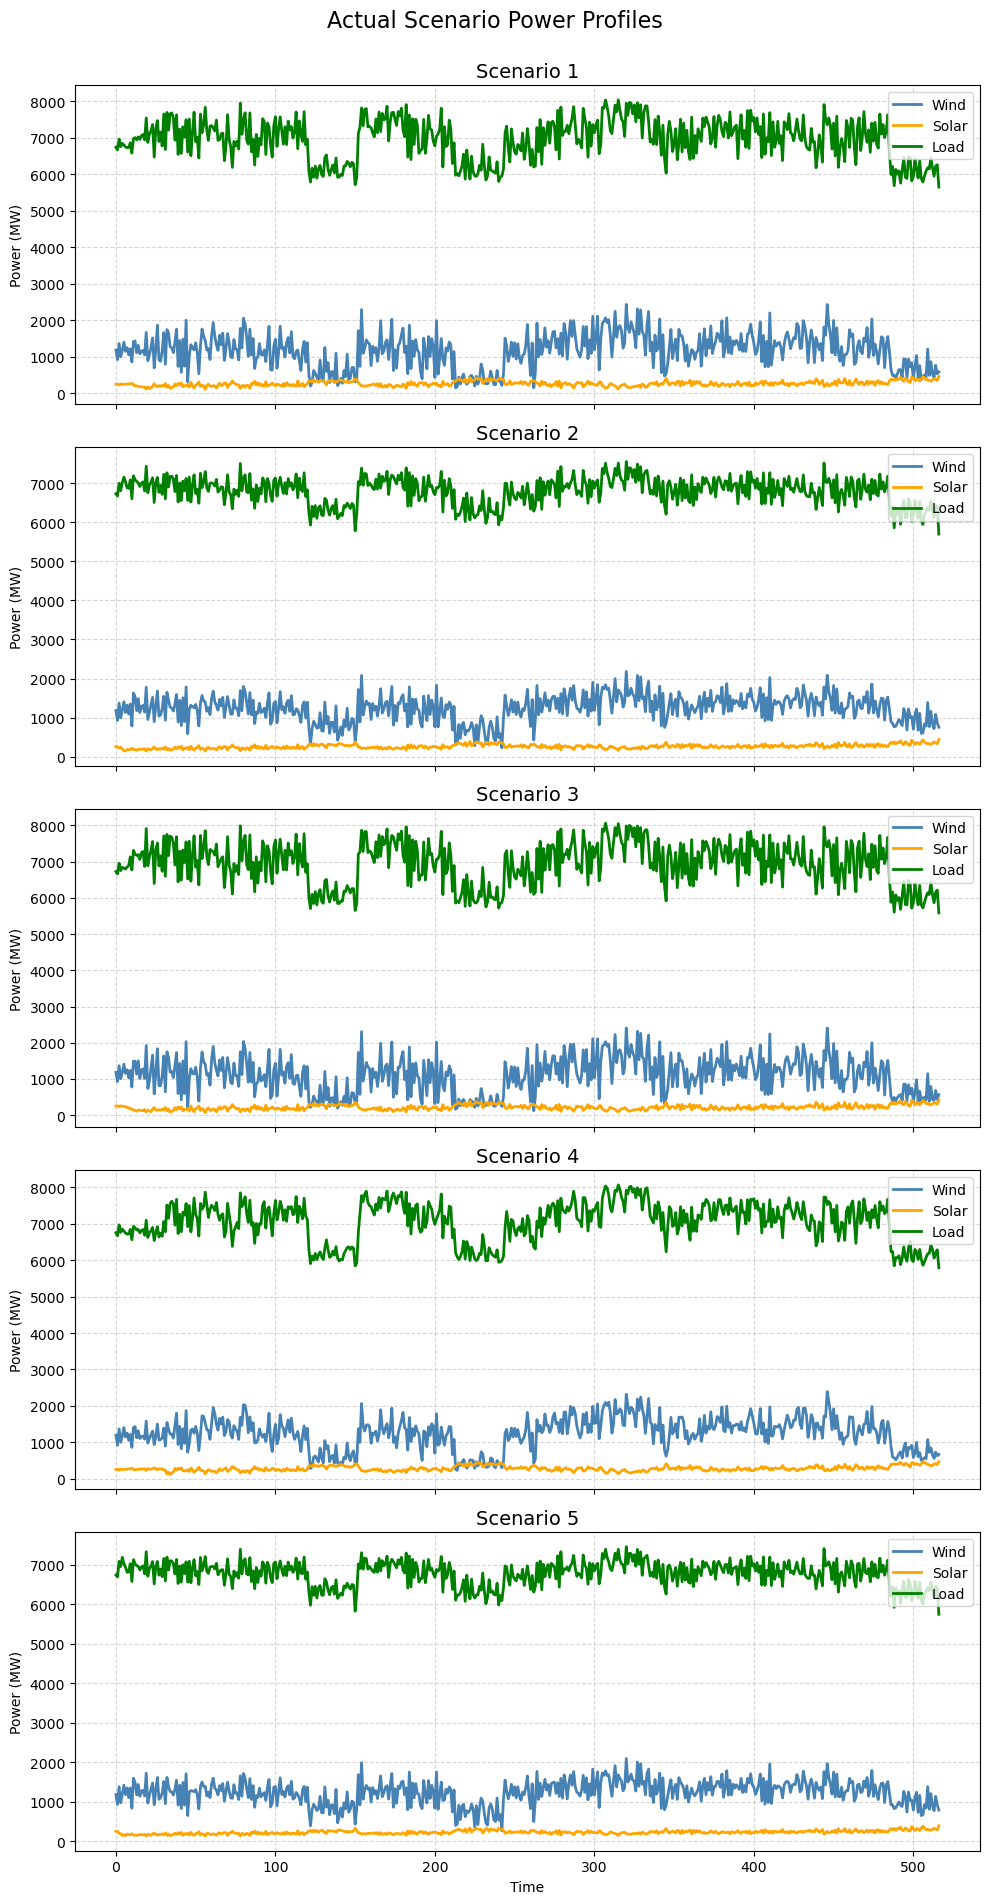

In [54]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 20),sharex=True)
fig.suptitle('Actual Scenario Power Profiles', fontsize=16, y=0.95)
for i, ax in enumerate(axes, start=1):
    ax.plot(actual_scenario[f'Wind_{i}'],label='Wind',color='steelblue',linewidth=2)
    ax.plot(actual_scenario[f'Solar_{i}'],label='Solar',color='orange',linewidth=2)
    ax.plot(actual_scenario[f'Load_{i}'],label='Load',color='green',linewidth=2)

    ax.set_title(f'Scenario {i}', fontsize=14)
    ax.set_ylabel('Power (MW)')

    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.5)

axes[-1].set_xlabel('Time')

# Adjust spacing to accommodate the suptitle
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
    
